In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import pytz
import sched
import speedtest as st
import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


TIMEZONE = pytz.timezone("Europe/London")
plt.style.use('dark_background')

PRINT_ONLY = False

In [3]:
def get_new_speeds() -> tuple[float, float, float]:
    try:
        speed_test = st.Speedtest()    
        speed_test.get_best_server()
    except:
        return None, None, None
    
    # Get ping (milliseconds)
    ping = speed_test.results.ping
    # Perform download and upload speed tests (bits per second)
    download = speed_test.download()
    upload = speed_test.upload()

    # Convert download and upload speeds to megabits per second
    download_mbs = round(download / (10**6), 2)
    upload_mbs = round(upload / (10**6), 2)

    return (ping, download_mbs, upload_mbs)


def update_csv(internet_speeds: tuple[float, float, float], csv_file_name: str = "data/internet_speeds_dataset.csv", verbose: bool = True):
    time_now = dt.datetime.now().replace(tzinfo=TIMEZONE).strftime('%Y-%m-%d %H:%M:%S.%f %Z')
    if verbose:
        print(time_now)

    # Load the CSV to update
    try:
        csv_dataset = pd.read_csv(csv_file_name, sep=",", index_col="Time")
    # If there's an error, assume the file does not exist and create\
    # the dataset from scratch
    except:
        csv_dataset = pd.DataFrame(
            list(),
            columns=["Ping (ms)", "Download (Mb/s)", "Upload (Mb/s)"]
        )

    # Create a one-row DataFrame for the new test results
    results_df = pd.DataFrame(
        [[ internet_speeds[0], internet_speeds[1], internet_speeds[2] ]],
        columns=["Ping (ms)", "Download (Mb/s)", "Upload (Mb/s)"],
        index=[time_now]
    )

    updated_df = csv_dataset.append(results_df, sort=False)
    updated_df.loc[~updated_df.index.duplicated(keep="last")].to_csv(csv_file_name, sep=",", index_label="Time")
    
    
def get_new_speeds_and_update(csv_file_name: str = "data/internet_speeds_dataset.csv", verbose: bool = True):
    update_csv(get_new_speeds(), csv_file_name, verbose)

In [4]:
if not PRINT_ONLY:
    scheduler = sched.scheduler(time.time, time.sleep)

    
    def repeat_task():
        scheduler.enter(0, 1, get_new_speeds_and_update, ())
        scheduler.enter(30, 1, repeat_task, ())


    repeat_task()
    scheduler.run()

In [5]:
def print_data(df: pd.DataFrame, title: str = ""):
    fig, ax1 = plt.subplots(figsize=(14, 10), nrows=1, ncols=1)

    lines_1 = ax1.step(df.index, df["Download (Mb/s)"], where="post", color="tab:blue", alpha=0.2)
    lines_1 = ax1.plot(df.index, df["Download (Mb/s)"].rolling("30Min").mean(), color="tab:blue", label=f"Download: {df['Download (Mb/s)'].mean():.0f} $\pm$ {df['Download (Mb/s)'].std():.0f} Mb/s")

    lines_2 = ax1.step(df.index, df["Upload (Mb/s)"], where="post", color="tab:red", alpha=0.2)
    lines_2 = ax1.plot(df.index, df["Upload (Mb/s)"].rolling("30Min").mean(), color="tab:red", label=f"Upload: {df['Upload (Mb/s)'].mean():.0f} $\pm$ {df['Upload (Mb/s)'].std():.0f} Mb/s")

    ax1.set_xlabel("Time", fontsize=15)
    ax1.set_ylabel("Speed", fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=15)

    ax2 = ax1.twinx()
    lines_3 = ax2.step(df.index, df["Ping (ms)"], where="post", color="tab:green", alpha=0.2)
    lines_3 = ax2.step(df.index, df["Ping (ms)"].rolling("30Min").mean(), where="post", color="tab:green", label="Ping (ms)")
    lines_3 = ax2.plot(df.index, df["Ping (ms)"].rolling("30Min").mean(), color="tab:green", label=f"Ping: {df['Ping (ms)'].mean():.0f} $\pm$ {df['Ping (ms)'].std():.0f} ms")

    ax2.set_ylabel("Ping", fontsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)

    lines = lines_1 + lines_2 + lines_3
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=15)
    
    ax1.set_title(title)
    
    plt.tight_layout()
    plt.show()

In [6]:
df = pd.read_csv("data/internet_speeds_dataset.csv", sep=",")
df['Time'] = df['Time'].str.replace(" LMT", "", regex=True)
df["Time"] = pd.to_datetime(df["Time"]).dt.tz_localize("Europe/London")
df = df.set_index("Time").sort_index()

today = dt.date.today()
morning = dt.datetime.combine(today, dt.datetime.strptime('0800','%H%M').time()).replace(tzinfo=TIMEZONE)
noon = dt.datetime.combine(today, dt.datetime.strptime('1200','%H%M').time()).replace(tzinfo=TIMEZONE)
afternoon = dt.datetime.combine(today, dt.datetime.strptime('1400','%H%M').time()).replace(tzinfo=TIMEZONE)
evening = dt.datetime.combine(today, dt.datetime.strptime('1800','%H%M').time()).replace(tzinfo=TIMEZONE)
today = dt.datetime.combine(today, dt.datetime.strptime('0000','%H%M').time()).replace(tzinfo=TIMEZONE)

df = df.loc[dt.date.today():]
df_morning = df.loc[morning:noon]
df_noon = df.loc[noon:afternoon]
df_afternoon = df.loc[afternoon:evening]
df_evening = df.loc[evening:]

/tmp/ipykernel_142311/624967402.py:13: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df = df.loc[dt.date.today():]


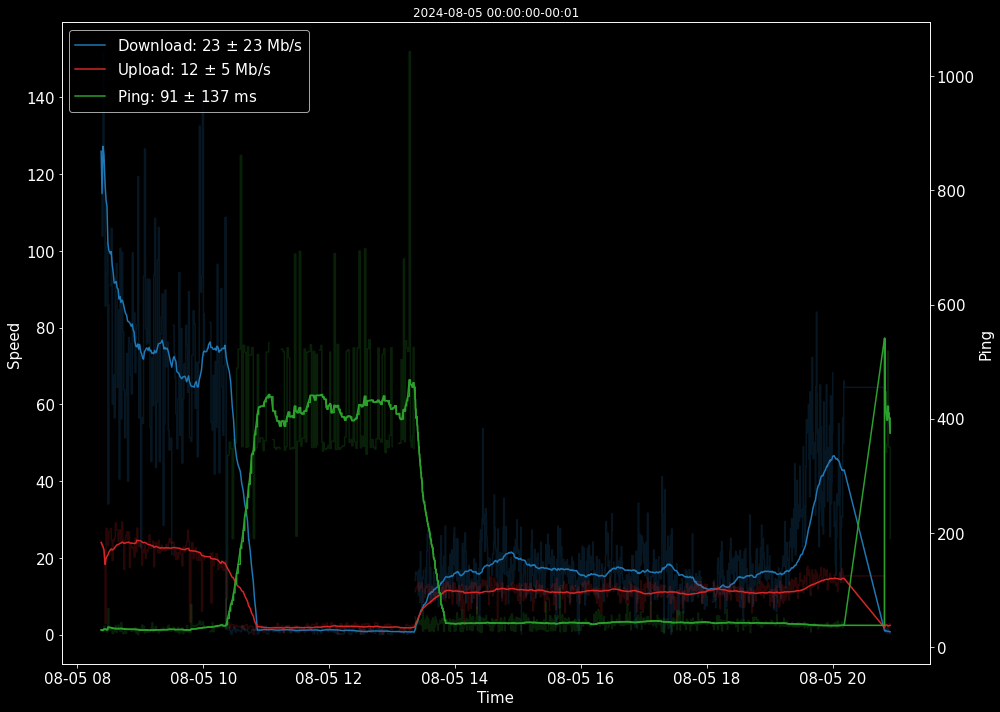

In [7]:
print_data(df, today)

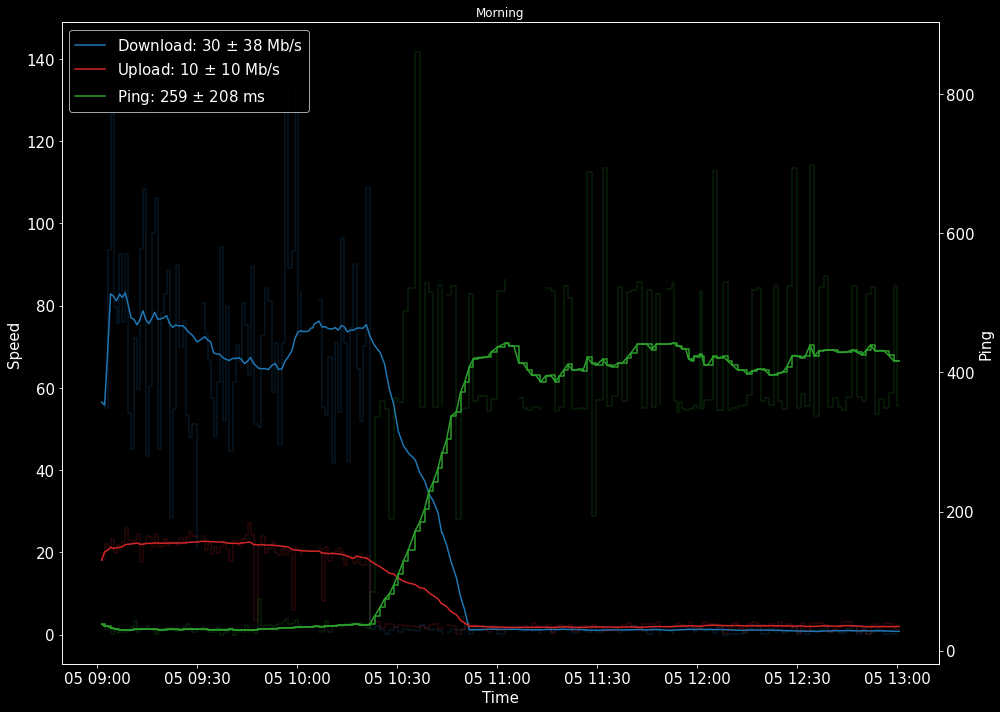

In [8]:
print_data(df_morning, "Morning")

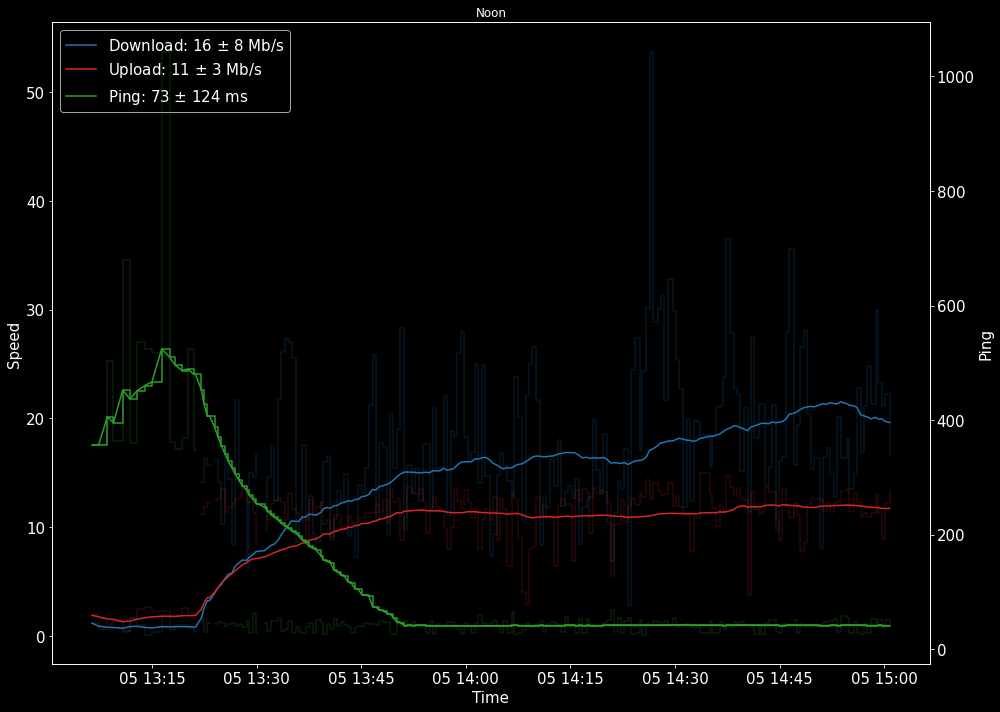

In [9]:
print_data(df_noon, "Noon")

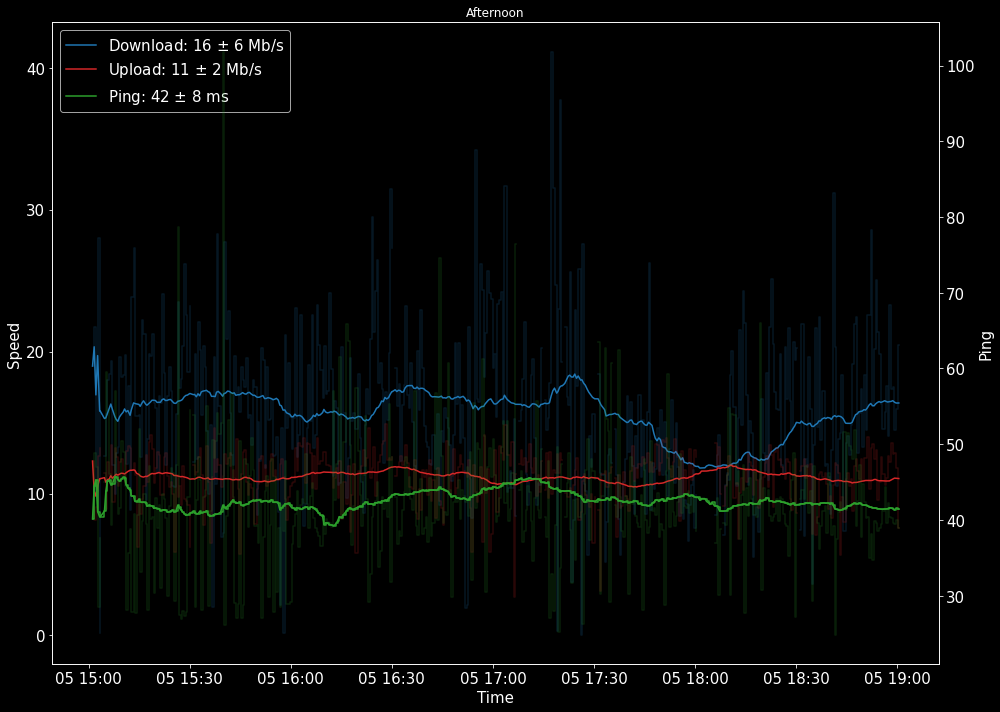

In [10]:
print_data(df_afternoon, "Afternoon")

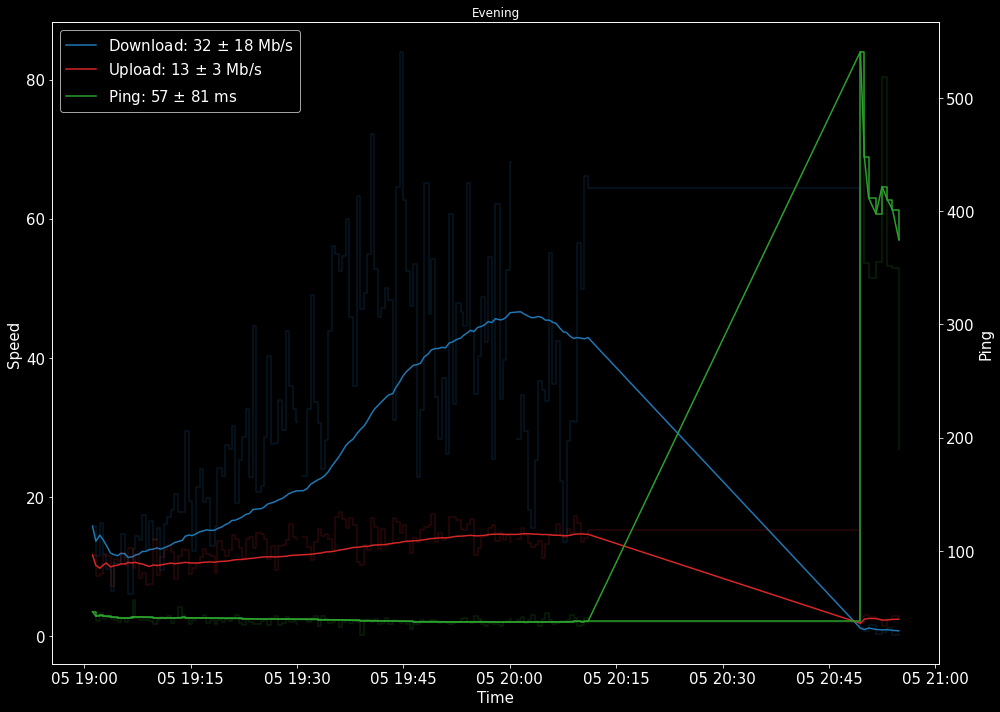

In [11]:
print_data(df_evening, "Evening")